# Direct Query Question Analysis

The 8 `adl-benchmark` questions were listed [here](README.md). The details of the models used to run over them can be found [here](models.yaml). This notebook is an analysis of the results.

The following was the *process* used:

1. Each question and model is done in isolation - nothing is learned or retained from one question to the next.
1. A prompt is assembled with the following contents:
    - [Some prompt text](https://github.com/gordonwatts/atlas-plot-agent/blob/d3a8363630234f16dc3248a092d5ff92d4c57b58/notebooks/adl-benchmarks/direct-query-config.yaml#L8)
    - [Hint files](https://github.com/gordonwatts/hep-programming-hints/tree/1.0.0)
    - The question (the question is sourced from the [README.md](README.md) file)
1. The LLM returns with some text and python code.
1. The python code is run in a docker container
1. If `png` files are produced as output, then the question is considered successfully answered (see the below section on hallucinations), and we move onto the next question.
1. If not, then a new prompt is assembled:
    - [Different prompt text](https://github.com/gordonwatts/atlas-plot-agent/blob/d3a8363630234f16dc3248a092d5ff92d4c57b58/notebooks/adl-benchmarks/direct-query-config.yaml#L30)
    - [Hint files](https://github.com/gordonwatts/hep-programming-hints/tree/1.0.0)
    - The question
    - The previous code
    - The error output from the code
1. The LLM replies again with an error analysis and code, at which point we go back to the step above where we run the code in the docker container.
1. This loop was run, for these steps, up to a max of three times.

All the back and forth is recorded in the files in this repo, like [`direct-question-01.md`](direct-question-01.md).

One thing to note: the performance is dependent on the hint files! Some errors below could be avoided by better hint files.

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import yaml

Parameterize the funning

In [2]:
results_dir = "plan-query"

In [3]:
# Parameters
results_dir = "plan-query"


The CSV results are written into all the `direct-question-xx.md` files found in this same directory. Use the following command to build a `results.csv` file which we can read in:

```bash
python ./notebooks/adl-benchmarks/query-results-to-pandas.py ./notebooks/adl-benchmarks/direct-question-*.md
```

In [4]:
!python query-results-to-pandas.py results/{results_dir}/*-question-*.md
results_csv = Path(f"results/{results_dir}/results.csv")
if results_csv.exists():
    results_csv.unlink()
Path("results.csv").rename(results_csv)

Saved combined CSV to results.csv


WindowsPath('results/plan-query/results.csv')

In [5]:
data = pd.read_csv(results_csv)
data.describe()

,Time,PromptTokens,CompletionTokens,TotalTokens,EstimatedCost,Attempts,CodeTime
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,87.256985,30347.095588,7802.676471,38149.772059,0.043221,6.661765,59.038676
std,76.527898,13789.590905,8418.521396,19385.587683,0.052929,1.545462,76.366104
min,8.690000,11691.000000,322.000000,12013.000000,0.001000,5.000000,0.000000
25%,36.837500,18670.500000,2675.250000,24170.500000,0.004750,5.000000,31.375000
50%,64.010000,26743.500000,4551.500000,33222.000000,0.019000,7.000000,52.360000
75%,110.607500,34836.750000,9435.250000,44942.250000,0.063500,7.000000,62.907500
max,434.080000,71310.000000,42955.000000,103806.000000,0.248000,11.000000,843.790000


## Preprocessing the data

You could argue this should be done in a support file. You'd be right.

In [6]:
# Turn the question number into something we can easily reason about
data['question'] = data['source_file'].apply(lambda x: int(re.search(r'-question-(\d+)', x).group(1)))

In [7]:
# Load models.yaml so that we can get from the detailed model name to the "nick-name"
with open("models.yaml", "r") as f:
    models = yaml.safe_load(f)["models"]

nickname_lookup = {models[name]["model_name"]: name for name in models.keys()}
# data['model_nickname'] = data['Model'].map(nickname_lookup)
data["model_nickname"] = data["Model"]

In [8]:
data.columns

Index(['Model', 'Time', 'PromptTokens', 'CompletionTokens', 'TotalTokens',
       'EstimatedCost', 'Attempts', 'CodeTime', 'Result', 'source_file',
       'question', 'model_nickname'],
      dtype='object')

## Model Cost

These models have a wide range of costs! The individual costs need to be pulled from the `models.yaml` file.

In [9]:
# Extract model names and output costs
model_costs = [(name, info.get('output_cost_per_million', 'N/A')) for name, info in models.items()]

model_info = pd.DataFrame(model_costs, columns=["model_name", "output_cost_per_million"])

In [10]:
model_info_sorted = model_info.sort_values(by="output_cost_per_million", ascending=False)
model_info_sorted

,model_name,output_cost_per_million
10,claude-sonnet-4,15.00
4,gpt-4o,10.00
1,gpt-5,10.00
0,gpt-4.1,8.00
5,o4-mini,4.40
11,gemini-2.5-flash,2.50
2,gpt-5-mini,2.00
8,Qwen3-Coder-480B,2.00
12,deepseek-chat-v3-0324,0.88
9,coder-large,0.80


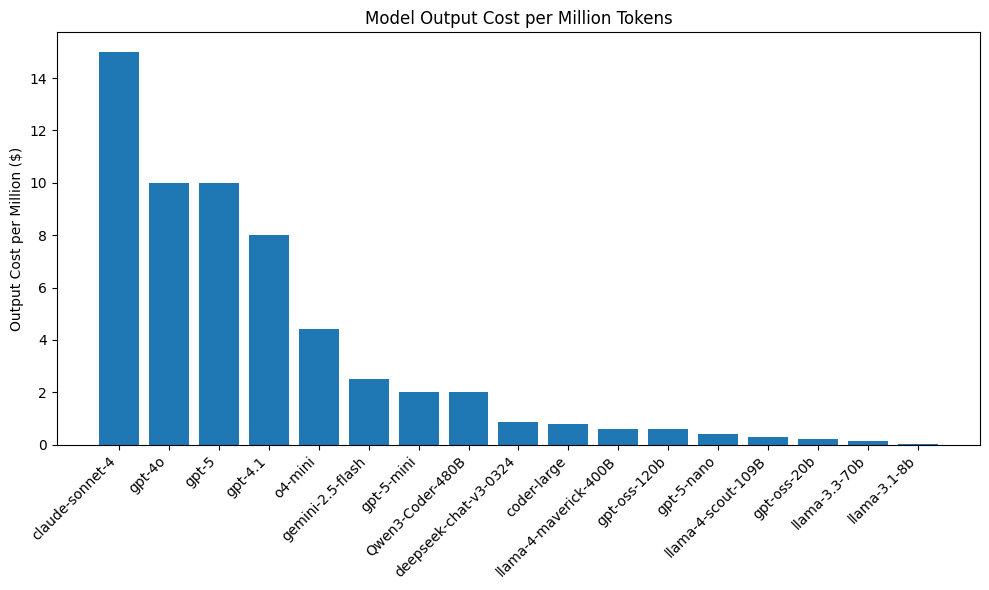

In [11]:
# Plot model costs
plt.figure(figsize=(10, 6))
plt.bar(model_info_sorted['model_name'], model_info_sorted['output_cost_per_million'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Output Cost per Million ($)')
plt.title('Model Output Cost per Million Tokens')
plt.tight_layout()
plt.show()

Look for duplicate information - which can be lethal later one

In [12]:
# ...existing code...
# Find duplicate (question, model_nickname) pairs
dupes = data[data.duplicated(subset=["question", "model_nickname"], keep=False)]
print("Duplicate rows for (question, model_nickname):")
print(dupes[["question", "model_nickname", "Result", "Model"]])
# ...existing code...

Duplicate rows for (question, model_nickname):
Empty DataFrame
Columns: [question, model_nickname, Result, Model]
Index: []


## Success and Attempts

Below is a complex grid plot that attempts to summarize this.

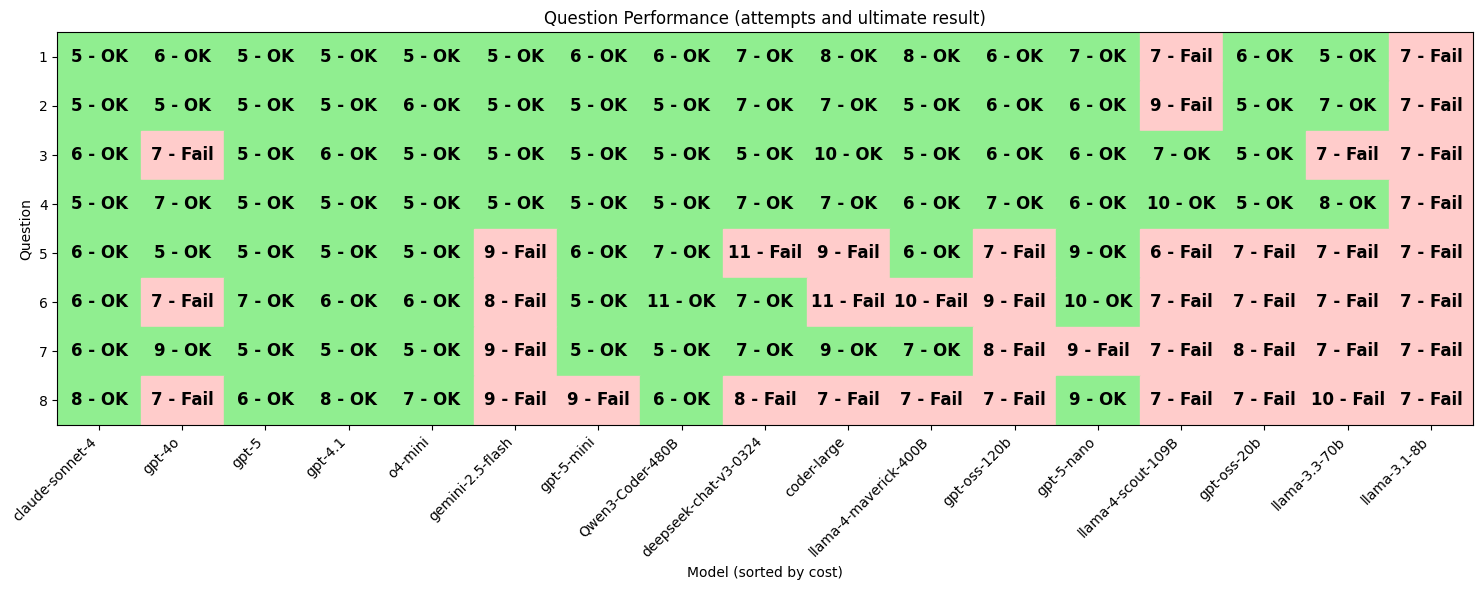

In [13]:
import numpy as np

# Prepare pivot table for grid, with columns sorted by model cost
sorted_nicknames = model_info_sorted['model_name'].tolist()
pivot = data.pivot(index='question', columns='model_nickname', values='Result')
pivot = pivot.reindex(columns=sorted_nicknames)

# Prepare attempts table for text labels
attempts_pivot = data.pivot(index='question', columns='model_nickname', values='Attempts')
attempts_pivot = attempts_pivot.reindex(columns=sorted_nicknames)

# Map results to colors
color_map = pivot.map(lambda x: '#90ee90' if x == 'Success' else '#ffcccb')  # light green/red

fig, ax = plt.subplots(figsize=(15, 6))

for (i, question) in enumerate(pivot.index):
    for (j, model) in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Show number of attempts as text label
        attempts = attempts_pivot.loc[question, model]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{attempts} - {'OK' if pivot.loc[question, model] == 'Success' else 'Fail'}",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel('Model (sorted by cost)')
ax.set_ylabel('Question')
ax.set_title('Question Performance (attempts and ultimate result)')
plt.tight_layout()
plt.show()

Some observations:

- There is a definite break between questions 4 and 5, and 5 and 6.
- Note that `gtp-oss-20b` sometimes fails with 1 attempt. That is because the model returns no code with the prompt.
- On average, performance is flash-ish across costs, which I find amazing, except for `gpt-5`.

## Questions 4, 5, and 6

Repeating questions 4, 5, and 6 here for reference:

4. Plot the ETmiss of events that have at least two jets with pT > 40 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697.
5. Plot the ETmiss of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697.
6. For events with at least three jets, plot the pT of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum b-tagging discriminant value among the jets in this trijet in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697.

- Question 4 is a 2 objet (ETmiss and jets) question. The aggregation is just counting, which is then cut on.
- Question 5 is a 2 object (ETMiss and muons) question. The filtering is 2-object (opposite sign). The aggregation is the invariant mass calculation, which is then cut on.
- Question 6 is a 1 object (jets) question. But two plots. The b-tagging discriminate value in ATLAS requires a fair amount of extra code. Aggregation is 3-jet combinatorics, and then you have to pick the best b-tagging discriminate from that.

These questions certainly are increasingly more difficult.

## Hallucinations

While I did cursory inspections of the models output, the above plot makes it clear there might be some more careful investigation required. In particular, `coder-large` and `gtp-5-nano` both seem to have successes on question 8, which is very rare! In general, it seems that the change from question 4, to 5, and to 6 causes trouble.

The below table is one that lists cases where the models made the plots, but the plots are incorrect. The code is:

* **"H"** Straight up hallucination
* **"K"** Made some comment in `stdout` or `stderr` which indicated it knew something was wrong and needed a human to peer over its shoulder.

In [14]:
human_review_all = {
    "direct-query": [
        ("5", "gpt-4o", "H"),  # Bad calc
        ("5", "o4-mini", "H"),  # ignores muons
        ("6", "gpt-5-mini", "H"),  # only one plot
        ("6", "gpt-5-nano", "H"),  # only one plot (and wrong)
        ("6", "Qwen3-Coder-480B", "H"),  # only one plot
        ("6", "deepseek-chat-v3-0324", "H"),  # empty plots
        ("7", "gpt-5-nano", "H"),  # bad calc and used loops!
        ("7", "o4-mini", "H"),  # Put in zeros
        ("7", "llama-4-maverick-400B", "H"),  # plotted jets
    ],
    "plan-query": [
        ("4", "gpt-5-mini", "H"),  # Forgets to apply the cut!
        ("4", "gpt-oss-120b", "H"),  # Not clear
        ("4", "llama-3.3-70b", "H"),  # Not clear
        ("5", "gpt-5-nano", "H"),  # Empty plot
        ("5", "Qwen3-Coder-480B", "H"),  # Not clear
        ("6", "gpt-5-nano", "H"),  # makes up btag disc
        ("6", "o4-mini", "H"),  # Wrong plot emitted!
        ("6", "Qwen3-Coder-480B", "H"),  # Empty plots
        ("6", "deepseek-chat-v3-0324", "H"),  # Empty plots
        ("7", "gpt-4.1", "H"),  # Put in zeros
        ("7", "o4-mini", "H"),  # Put in zeros
        ("7", "claude-sonnet-4", "H"),  # Put in zeros
        ("8", "gpt-5-nano", "H"),  # odd tail
        ("8", "claude-sonnet-4", "H"),  # plots wrong thing
    ],
}

# Pick the right set of results for this current work.
human_review = human_review_all[results_dir]

Adding this information to the table so we can make another "nice" grid plot.

In [15]:
# Add hallucination and corrected result columns
hallucination_map = {(int(q), m): h for q, m, h in human_review}
data['hallucination'] = data.apply(lambda row: hallucination_map.get((row['question'], row['model_nickname']), ''), axis=1)
def correct_result(row):
    if row['hallucination'] in ['H', 'K'] and row['Result'] == 'Success':
        return 'Fail'
    return row['Result']
data['Result_with_hallucination'] = data.apply(correct_result, axis=1)

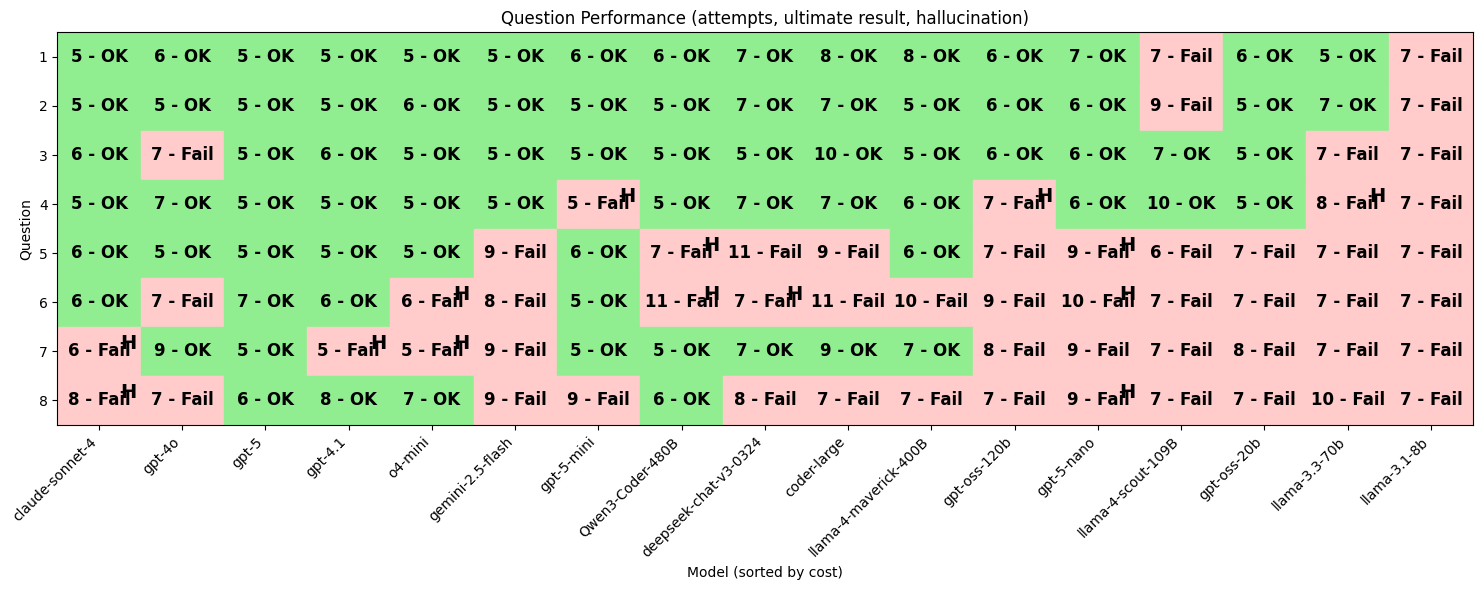

In [16]:
import numpy as np

# Prepare pivot table for grid, with columns sorted by model cost
sorted_nicknames = model_info_sorted["model_name"].tolist()
pivot = data.pivot(
    index="question", columns="model_nickname", values="Result_with_hallucination"
)
pivot = pivot.reindex(columns=sorted_nicknames)

# Prepare attempts table for text labels
attempts_pivot = data.pivot(
    index="question", columns="model_nickname", values="Attempts"
)
attempts_pivot = attempts_pivot.reindex(columns=sorted_nicknames)

# Prepare hallucination table for annotation
hallucination_pivot = data.pivot(
    index="question", columns="model_nickname", values="hallucination"
)
hallucination_pivot = hallucination_pivot.reindex(columns=sorted_nicknames)

# Map results to colors
color_map = pivot.map(
    lambda x: "#90ee90" if x == "Success" else "#ffcccb"
)  # light green/red

fig, ax = plt.subplots(figsize=(15, 6))

for i, question in enumerate(pivot.index):
    for j, model in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Show number of attempts as text label
        attempts = attempts_pivot.loc[question, model]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{attempts} - {'OK' if pivot.loc[question, model] == 'Success' else 'Fail'}",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )
        # If hallucination is non-empty, show letter in upper right
        hallucination = hallucination_pivot.loc[question, model]
        if isinstance(hallucination, str) and hallucination.strip():
            ax.text(
                j + 0.95,
                i + 0.15,
                hallucination,
                ha="right",
                va="top",
                fontsize=14,
                fontweight="bold",
                color="black",
            )

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel("Model (sorted by cost)")
ax.set_ylabel("Question")
ax.set_title("Question Performance (attempts, ultimate result, hallucination)")
plt.tight_layout()
plt.show()

## Question Cost

Finally, we can look at the cost of a success or a fail for each question. This must be taken with a grain of salt - this is a single try with each LLM and question. However, given cost is driven by size of input and size of output, it is likely that this is accurate (just not the pass/fail).

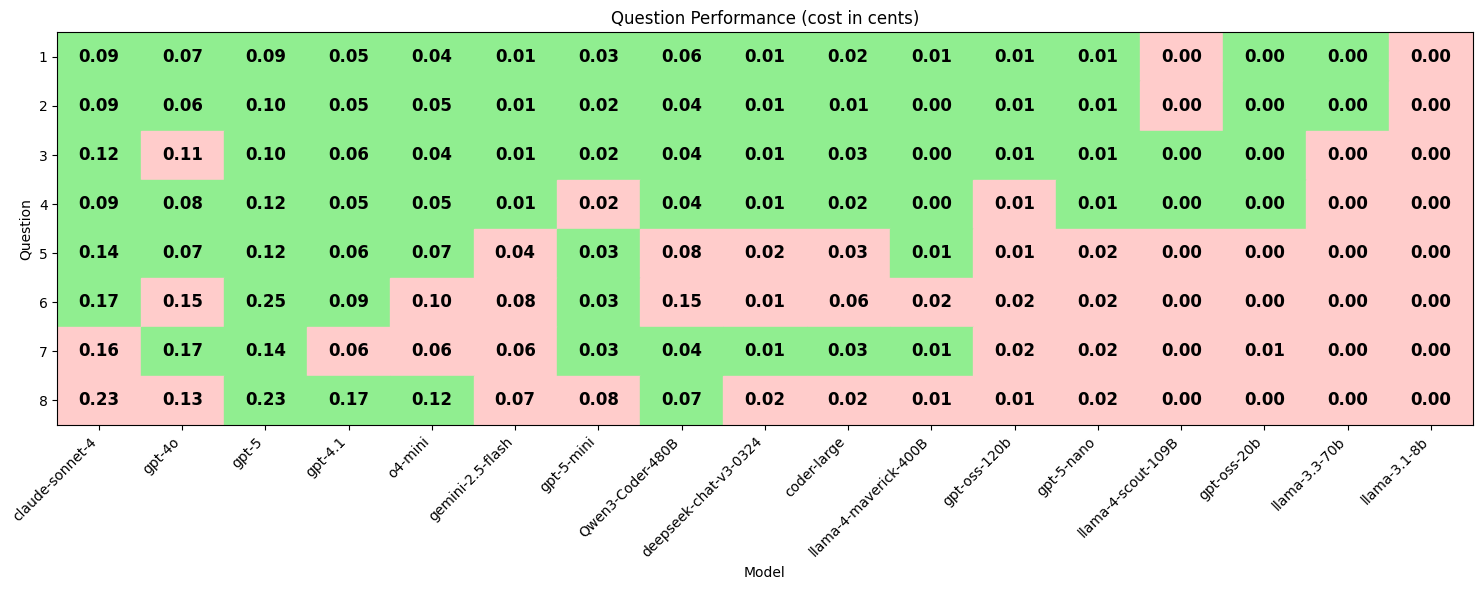

In [17]:
import numpy as np

# Prepare pivot table for grid, with columns sorted by model cost
sorted_nicknames = model_info_sorted["model_name"].tolist()
pivot = data.pivot(
    index="question", columns="model_nickname", values="Result_with_hallucination"
)
pivot = pivot.reindex(columns=sorted_nicknames)

# Prepare cost table for text labels (convert to cents)
cost_pivot = data.pivot(
    index="question", columns="model_nickname", values="EstimatedCost"
)
cost_pivot = cost_pivot.reindex(columns=sorted_nicknames)

# Prepare hallucination table for annotation
hallucination_pivot = data.pivot(
    index="question", columns="model_nickname", values="hallucination"
)
hallucination_pivot = hallucination_pivot.reindex(columns=sorted_nicknames)

# Map results to colors
color_map = pivot.map(
    lambda x: "#90ee90" if x == "Success" else "#ffcccb"
)  # light green/red

fig, ax = plt.subplots(figsize=(15, 6))

for i, question in enumerate(pivot.index):
    for j, model in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Show cost in cents as text label
        cost = cost_pivot.loc[question, model]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{cost:.2f}",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel("Model")
ax.set_ylabel("Question")
ax.set_title("Question Performance (cost in cents)")
plt.tight_layout()
plt.show()

A few things to note here:

- Given the way that the code works, the cost goes as the number of attempts.
- An expensive model that gets it right on the first try is cheaper than a less expensive model that has to take several iterations.

Which model is the least expensive successful model on each question?

In [18]:
# Find the cheapest successful model for each question
cheapest_success = (
    data[data['Result_with_hallucination'] == 'Success']
    .groupby('question')
    .apply(lambda df: df.loc[df['EstimatedCost'].idxmin()])
)

cheapest_df = cheapest_success[['question', 'model_nickname', 'EstimatedCost']].reset_index(drop=True)
cheapest_df.rename(columns={'model_nickname': 'CheapestModel', 'EstimatedCost': 'CheapestCost'}, inplace=True)
cheapest_df

C:\Users\gordo\AppData\Local\Temp\ipykernel_30960\881444520.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.loc[df['EstimatedCost'].idxmin()])


,question,CheapestModel,CheapestCost
0,1,llama-3.3-70b,0.001
1,2,llama-3.3-70b,0.001
2,3,gpt-oss-20b,0.002
3,4,gpt-oss-20b,0.002
4,5,llama-4-maverick-400B,0.005
5,6,gpt-5-mini,0.032
6,7,llama-4-maverick-400B,0.006
7,8,Qwen3-Coder-480B,0.067


It would be nice to know the answer to the question: if you had to pick one model, which is the cheapest? The answer, however, is gpt-5 currently, as it is the only model that successfully answered all questions.